0.00017947336268325266
Simulating Type Ia supernova with:
  Redshift (z): 0.1
  Absolute B magnitude: 20.0
  Stretch (x1): 0.5
  Color (c): 0.0
  Amplitude (x0): 0.000179

Simulating light curve...
SNR: 16.535408591467437
Plotting light curve...


/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_79981/3792760410.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + lc['zp'][mask]


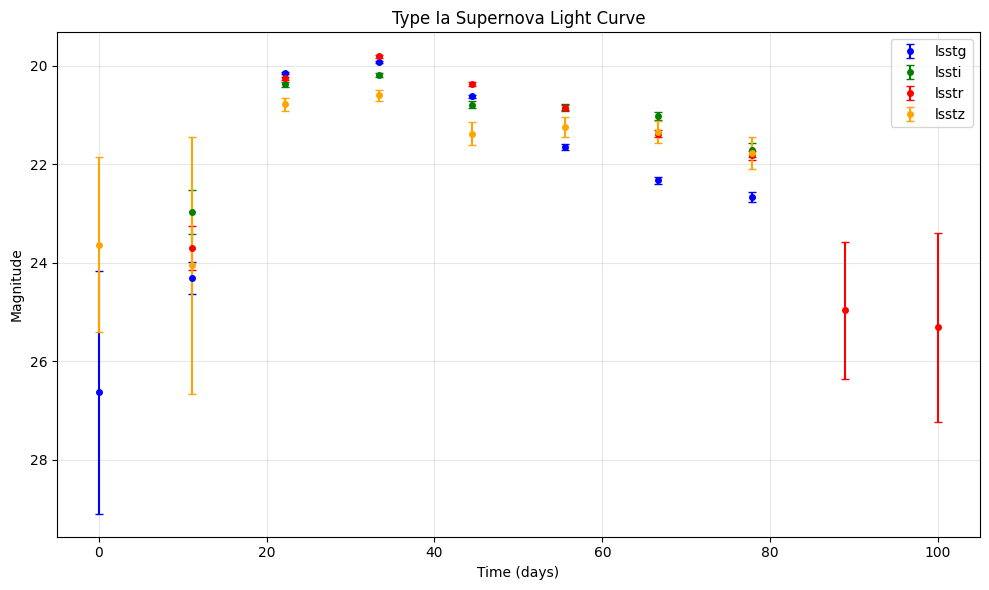

In [1]:
import numpy as np
import sncosmo
from astropy.table import Table
import matplotlib.pyplot as plt

times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(ia_obs, this_ia_model, [params])
    r_band_mask = lcs[0]['band'] == 'lsstr'
    snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    print("SNR:", snr)

    return lcs

def fit_ia(true_z, lcs):    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    return result, fitted_model

def plot_light_curve(lc):
    """
    Plot the light curve in different bands
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get unique bands
    bands = np.unique(lc['band'])
    colors = ['blue', 'green', 'red', 'orange']
    
    for i, band in enumerate(bands):
        mask = lc['band'] == band
        time = lc['time'][mask]
        flux = lc['flux'][mask]
        fluxerr = lc['fluxerr'][mask]
        
        # Convert flux to magnitude
        mag = -2.5 * np.log10(flux) + lc['zp'][mask]
        magerr = np.abs(2.5 / np.log(10) * fluxerr / flux)
        
        ax.errorbar(time, mag, yerr=magerr, fmt='o', 
                   label=f'{band}', color=colors[i % len(colors)], 
                   capsize=3, markersize=4)
    
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Magnitude')
    ax.set_title('Type Ia Supernova Light Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Brighter objects have lower magnitudes
    
    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to simulate a Type Ia supernova and fit its light curve
    """
    # Define supernova parameters
    true_z = 0.1  # redshift
    t0 = 30.0      # time of maximum brightness
    mb = 20.0    # absolute B-band magnitude
    x0 = get_x0(mb)  # amplitude parameter
    x1 = 0.5      # stretch parameter
    c = 0.0       # color parameter
    print(x0)
    
    print(f"Simulating Type Ia supernova with:")
    print(f"  Redshift (z): {true_z}")
    print(f"  Absolute B magnitude: {mb}")
    print(f"  Stretch (x1): {x1}")
    print(f"  Color (c): {c}")
    print(f"  Amplitude (x0): {x0:.6f}")
    print()
    
    # Simulate the light curve
    print("Simulating light curve...")
    lcs = simulate_ia(true_z, t0, x0, x1, c)
    
    # Plot the light curve
    print("Plotting light curve...")
    plot_light_curve(lcs[0])
    
    return lcs

if __name__ == "__main__":
    lcs = main()

0.00017947336268325266
Simulating Type Ia supernova with:
  Redshift (z): 0.1
  Absolute B magnitude: 20.0
  Stretch (x1): 0.5
  Color (c): 0.0
  Amplitude (x0): 0.000179

Simulating light curve...
SNR: 16.96990960058632
Plotting light curve...


/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_79981/3792760410.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + lc['zp'][mask]


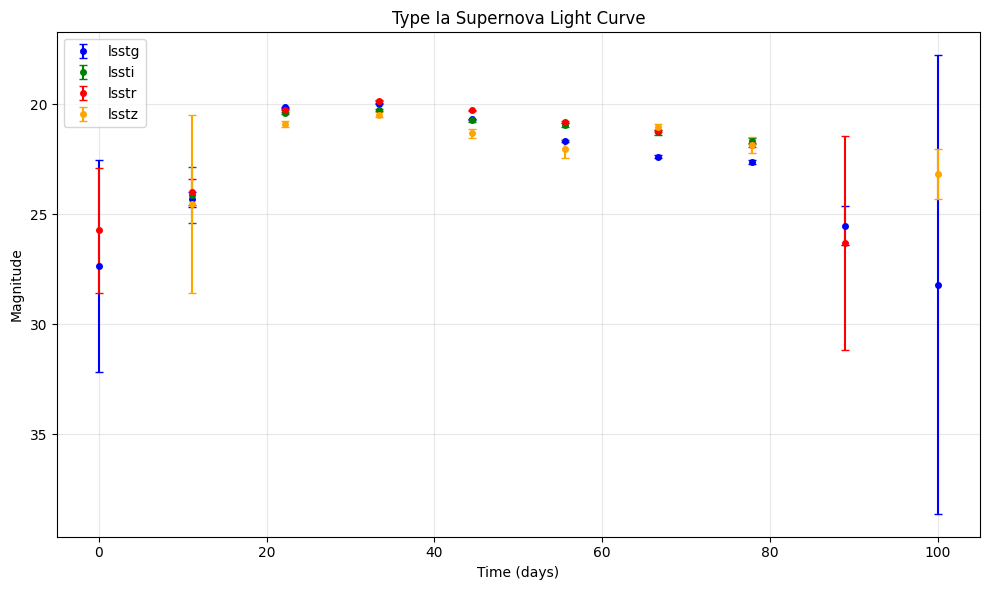

In [2]:
lcs = main()

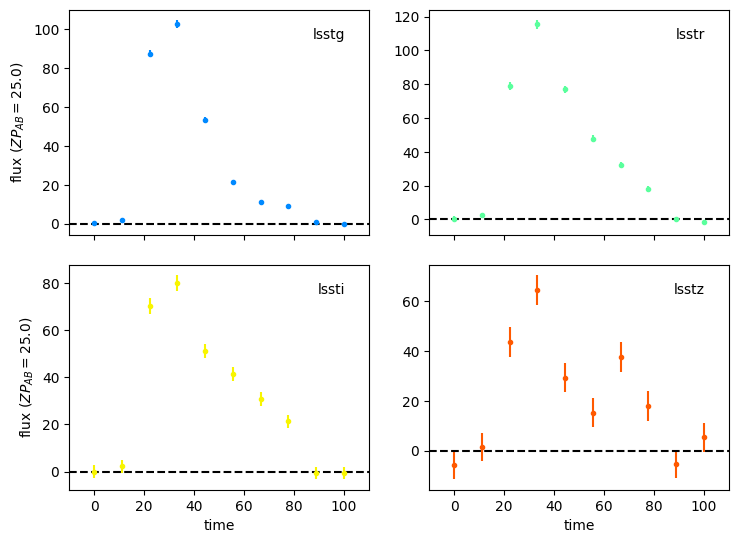

In [3]:
sncosmo.plot_lc(lcs[0]);

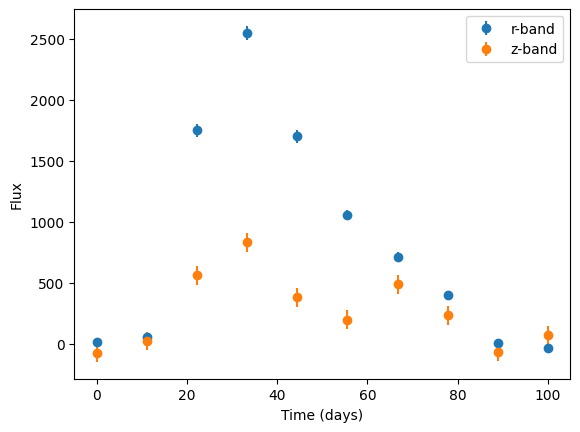

In [4]:
r_band_mask = lcs[0]['band'] == 'lsstr'
z_band_mask = lcs[0]['band'] == 'lsstz'


plt.errorbar(lcs[0]['time'][r_band_mask], lcs[0]['flux'][r_band_mask], yerr=lcs[0]['fluxerr'][r_band_mask], fmt='o', label='r-band')
plt.errorbar(lcs[0]['time'][z_band_mask], lcs[0]['flux'][z_band_mask], yerr=lcs[0]['fluxerr'][z_band_mask], fmt='o', label='z-band')
plt.xlabel('Time (days)')
plt.ylabel('Flux')
plt.legend()
plt.show()

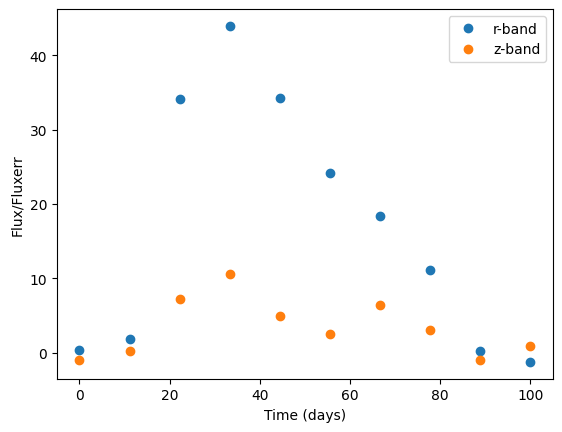

In [5]:
plt.errorbar(lcs[0]['time'][r_band_mask], lcs[0]['flux'][r_band_mask]/lcs[0]['fluxerr'][r_band_mask], fmt='o', label='r-band')
plt.errorbar(lcs[0]['time'][z_band_mask], lcs[0]['flux'][z_band_mask]/lcs[0]['fluxerr'][z_band_mask], fmt='o', label='z-band')
plt.xlabel('Time (days)')
plt.ylabel('Flux/Fluxerr')
plt.legend()
plt.show()

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture


rng = np.random.default_rng()

In [81]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c', 'log_x0']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej', 'log_fni']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [82]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
        # if self.true_class == 'ia':
        #     self.true_params = {key:true_dict[key] for key in self.ia_keys}
        # elif self.true_class == 'ibc':
        #     self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        # else:
        #     raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [120]:
data = np.load("fitted_sne_real_011326.npz", allow_pickle=True)

true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
len(true_ibc_sne), len(all_sne), len(true_ia_sne)/len(all_sne)


(251, 491, 0.48879837067209775)

In [121]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})

In [122]:
all_sne[100].true_class

'SN Ia'

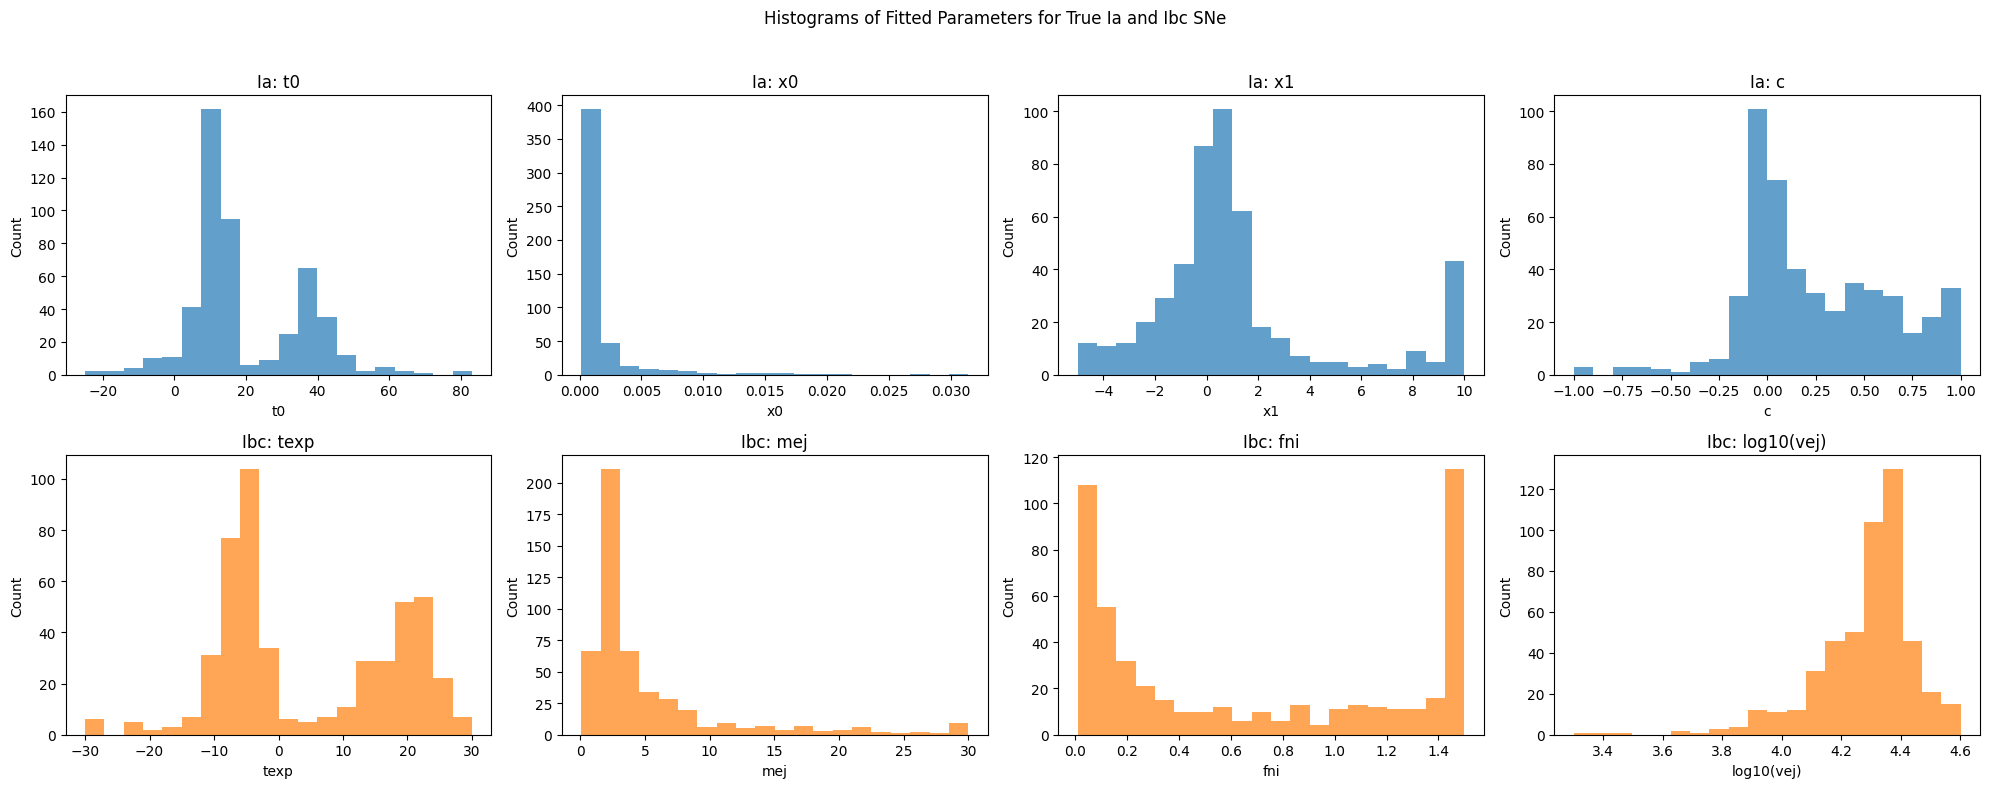

In [123]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names[:4]):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

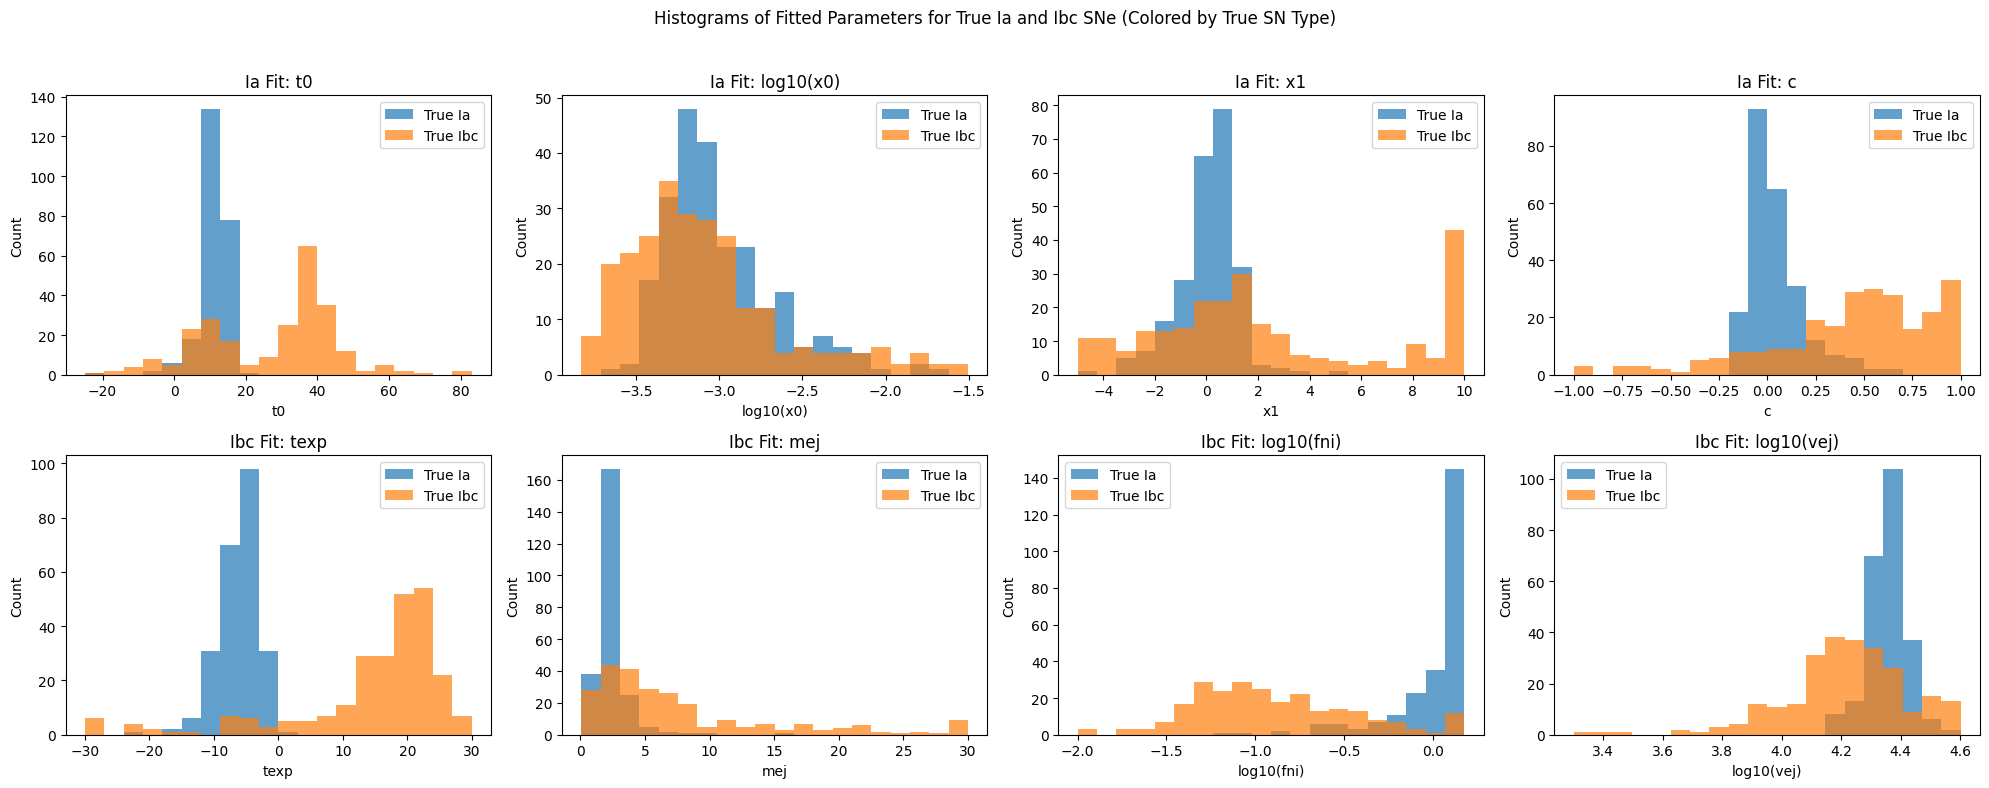

In [124]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe (Colored by True SN Type)")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names[:4]):
    ia_values = [sn.ia_fit[param] for sn in true_ia_sne if sn.ia_fit[param] is not None]
    ibc_values = [sn.ia_fit[param] for sn in true_ibc_sne if sn.ia_fit[param] is not None]
    if param == 'x0':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[0, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[0, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    if param == 'x0':
        axes[0, i].set_title(f"Ia Fit: log10({param})")
        axes[0, i].set_xlabel(f"log10({param})")
    else:
        axes[0, i].set_title(f"Ia Fit: {param}")
        axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    ia_values = [sn.ibc_fit[param] for sn in true_ia_sne if sn.ibc_fit[param] is not None]
    ibc_values = [sn.ibc_fit[param] for sn in true_ibc_sne if sn.ibc_fit[param] is not None]
    if param == 'vej' or param == 'fni':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[1, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[1, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    if param == 'vej' or param == 'fni':
        axes[1, i].set_title(f"Ibc Fit: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].set_title(f"Ibc Fit: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Here we have 8 parameters that we can use to constrain the mixing fraction

In [125]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [126]:
def get_param_samples(param_name):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in all_sne])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in all_sne])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([442.,  22.,  12.,   3.,   5.,   3.,   2.,   0.,   1.,   1.]),
 array([0.00014759, 0.00327196, 0.00639633, 0.00952069, 0.01264506,
        0.01576943, 0.0188938 , 0.02201817, 0.02514254, 0.02826691,
        0.03139128]),
 <BarContainer object of 10 artists>)

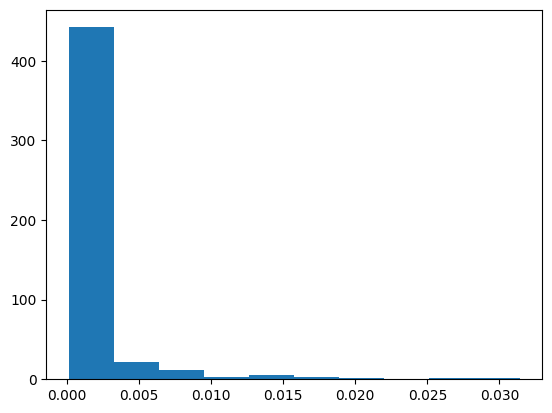

In [127]:
plt.hist(get_param_samples('x0'))

In [128]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(491, 1)

In [129]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    samples = get_param_samples(param_name).reshape(-1, 1)
    gm = GaussianMixture(n_components=2).fit(samples)
    mus_a[param_name] = gm.means_[0][0]
    mus_b[param_name] = gm.means_[1][0]
    sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    print(param_name, gm.weights_)

t0 [0.32002983 0.67997017]
c [0.66925085 0.33074915]
mej [0.69794856 0.30205144]
texp [0.4226649 0.5773351]
x1 [0.87316308 0.12683692]
log_x0 [0.77301281 0.22698719]
log_fni [0.78062046 0.21937954]
log_vej [0.78919124 0.21080876]


In [130]:
# from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(get_param_samples('x1').reshape(-1, 1))
gm.means_, gm.covariances_**0.5, gm.weights_

(array([[0.11137259],
        [9.35492912]]),
 array([[[1.90714876]],
 
        [[1.04688928]]]),
 array([0.87316308, 0.12683692]))

In [131]:
num_epochs = 200
lls = np.zeros(num_epochs)


# mus_a = {'t0': 20, 'x0': 0.0001, 'x1': 2, 'c': 0, 'texp': 0.5, 'mej': 8, 'fni': 0.05, 'log_vej': 4.3}
# mus_b = {'t0': 20, 'x0': 0.0001, 'x1': 0.5, 'c': 0.6, 'texp': 5, 'mej': 2, 'fni': 0.49, 'log_vej': 3.9}
# sigmas_a = {'t0': 10, 'x0': 5e-4, 'x1': 0.01, 'c': 0.1, 'texp': 0.2, 'mej': 2, 'fni': 0.01, 'log_vej': 0.05}
# sigmas_b = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.3, 'texp': 3, 'mej': 2, 'fni': 5e-2, 'log_vej': 0.2}


alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.1  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'log_fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'log_fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'x1': [], 'c': []}

params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']
# params_to_use = list(mus_a.keys())  # Use all parameters for fitting



# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)

        # plt.hist(param_samples)
        # plt.show()

        # print(mus_a[param_name], sigmas_a[param_name])
        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

        if sigmas_a[param_name] < 0.01:
            sigmas_a[param_name] = 0.01
        if sigmas_b[param_name] < 0.01:
            sigmas_b[param_name] = 0.01

    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], get_param_samples(param_name), alpha)

    

Alpha 0.46913857947509946
Alpha 0.5444351790305728
Alpha 0.5725197374078524
Alpha 0.5860241022469205
Alpha 0.5947494732373396
Alpha 0.6023346730897801
Alpha 0.6118029546194125
Alpha 0.624705680292255
Alpha 0.6351336485293629
Alpha 0.6418836294623187
Alpha 0.6467977581726405
Alpha 0.6505778966768292
Alpha 0.6535245249941304
Alpha 0.6558391974281753
Alpha 0.6576705903931344
Alpha 0.659128260149198
Alpha 0.6602934889010188
Alpha 0.6612276268612588
Alpha 0.6619778650287917
Alpha 0.6625810798171661
Alpha 0.6630664154809175
Alpha 0.6634570766301068
Alpha 0.6637716231166935
Alpha 0.6640249396400587
Alpha 0.6642289818101208
Alpha 0.6643933608535828
Alpha 0.6645258071360071
Alpha 0.6646325400886925
Alpha 0.6647185645446942
Alpha 0.6647879085955218
Alpha 0.6648438147006548
Alpha 0.6648888933114474
Alpha 0.6649252463900163
Alpha 0.6649545667341167
Alpha 0.6649782178535013
Alpha 0.664997298211459
Alpha 0.6650126928973518
Alpha 0.6650251151947453
Alpha 0.6650351400261644
Alpha 0.6650432308666175
Al

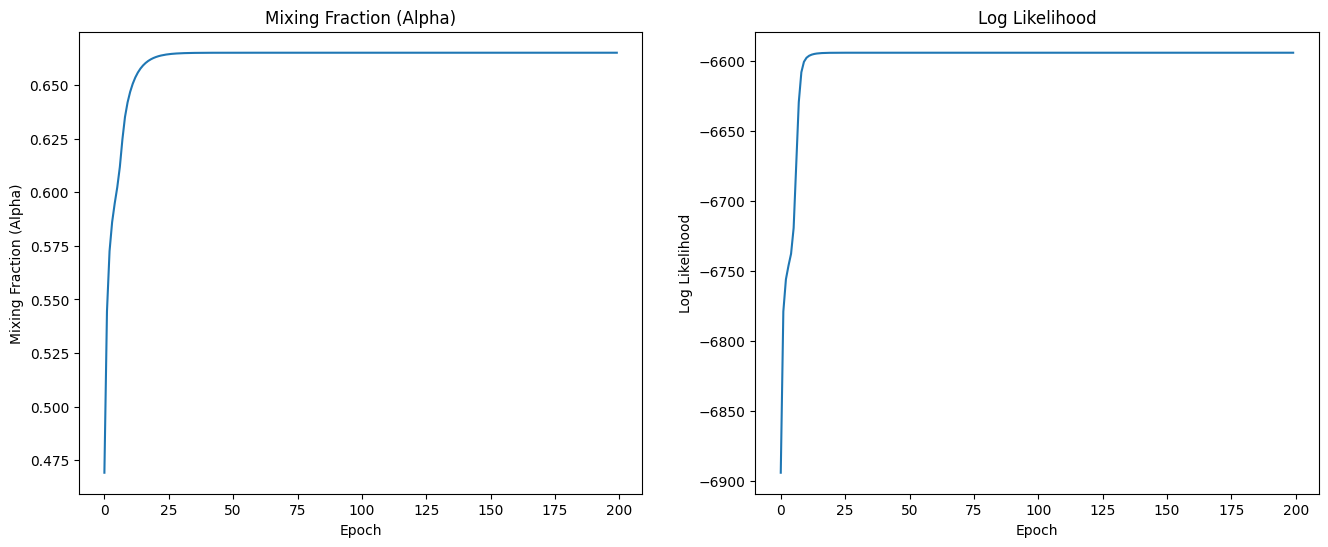

In [132]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [133]:
prob_a = np.ones(len(all_sne))

for i in range(len(all_sne)):
    s = 0
    b = 0
    for param in params_to_use:
        s += gammas_a[param][i]
        b += gammas_b[param][i]
    prob_a[i] = s / (s + b)

(array([  1.,  10.,  11.,  43.,  46., 146., 151.,  42.,  28.,  13.]),
 array([0.2491623 , 0.32061045, 0.39205859, 0.46350674, 0.53495489,
        0.60640304, 0.67785119, 0.74929934, 0.82074749, 0.89219564,
        0.96364379]),
 <BarContainer object of 10 artists>)

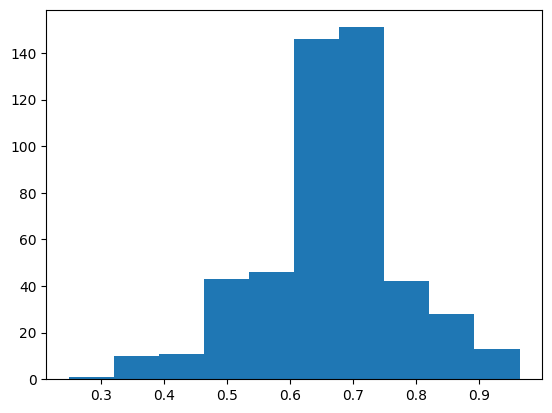

In [134]:
plt.hist(prob_a)

In [135]:
classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
true_classes = [sn.true_class for sn in all_sne]
# true_classes

In [136]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

238 39 2 212
0.5641547861507128


In [137]:
classifications_rough = np.ones(len(all_sne))
for i in range(len(all_sne)):
    probs = np.array([gammas_a[param][i] for param in params_to_use])
    num_a = sum(probs >= 0.5)
    if num_a >= 4:
        classifications_rough[i] = 0
classifications_rough = ['SN Ia' if i == 0 else 'SN Ibc' for i in classifications_rough]


In [138]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications_rough):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

240 17 0 234
0.5234215885947047


In [139]:
mus_a, mus_b, sigmas_a, sigmas_b

({'t0': 25.193755911452964,
  'c': 0.04202684001175298,
  'mej': 2.3481317061097755,
  'texp': 19.03912809331507,
  'x1': -0.007736060464565324,
  'log_x0': -3.2072547697417497,
  'log_fni': -0.6502425426239453,
  'log_vej': 4.3419800890912645},
 {'t0': 11.231936559011372,
  'c': 0.6932713943274355,
  'mej': 10.85703825390556,
  'texp': -6.6317824392451445,
  'x1': 8.816709870194211,
  'log_x0': -2.701928762847702,
  'log_fni': 0.17435184945462764,
  'log_vej': 4.177883031376829},
 {'t0': 18.338933170608705,
  'c': 0.24065113650437298,
  'mej': 1.0134098424939373,
  'texp': 4.92997451620303,
  'x1': 1.7536082818117202,
  'log_x0': 0.23853726019764493,
  'log_fni': 0.5410163185564716,
  'log_vej': 0.08144139266525646},
 {'t0': 2.685991717592454,
  'c': 0.21258703552438338,
  'mej': 7.555575992870531,
  'texp': 5.404317534423108,
  'x1': 1.7012730807381335,
  'log_x0': 0.4937623343187208,
  'log_fni': 0.01,
  'log_vej': 0.23390254698037363})

In [140]:
# for n in sigmas_b.keys():
#     if sigmas_b[n] <= 0.01:
#         sigmas_b[n] = 0.01

# for n in sigmas_a.keys():
#     if sigmas_a[n] <= 0.01:
#         sigmas_a[n] = 0.01

In [141]:
# sigmas_a['x0'] = 1e-5
# sigmas_b['x0'] = 1e-6

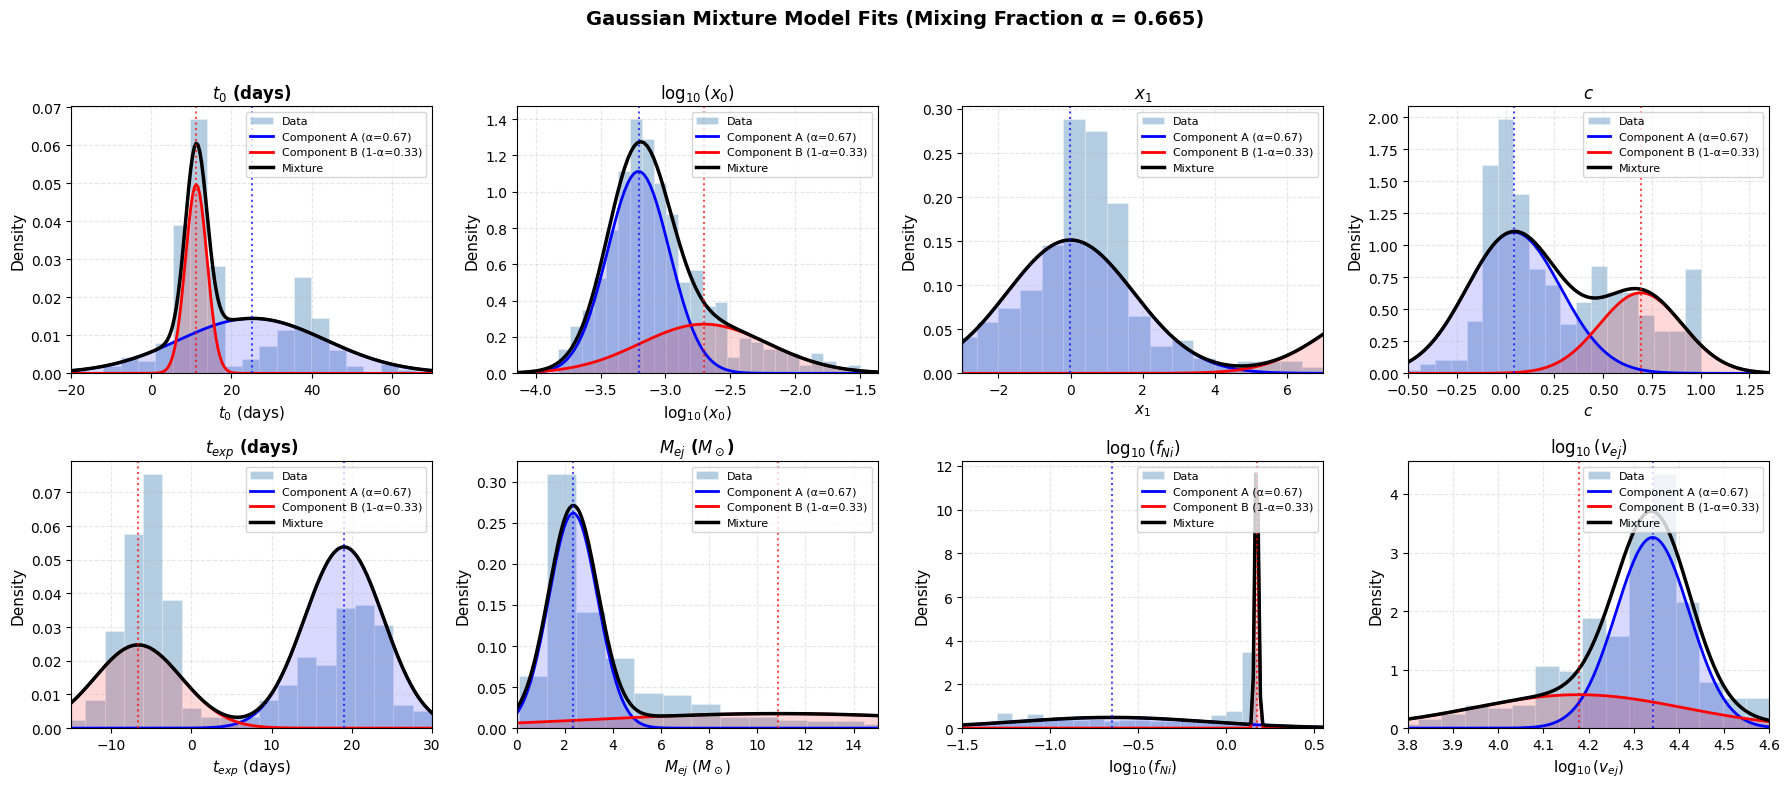


Fitted Gaussian Mixture Parameters:
----------------------------------------------------------------------
Parameter           μ_A        σ_A        μ_B        σ_B
----------------------------------------------------------------------
t0              25.1938    18.3389    11.2319     2.6860
log_x0          -3.2073     0.2385    -2.7019     0.4938
x1              -0.0077     1.7536     8.8167     1.7013
c                0.0420     0.2407     0.6933     0.2126
texp            19.0391     4.9300    -6.6318     5.4043
mej              2.3481     1.0134    10.8570     7.5556
log_fni         -0.6502     0.5410     0.1744     0.0100
log_vej          4.3420     0.0814     4.1779     0.2339


In [142]:
# Define x ranges for plotting
x_ranges = {
    't0': np.linspace(-20, 70, 200),
    'log_x0': np.linspace(-5, 0, 200),  # log10 scale for x0
    'x1': np.linspace(-3, 7, 200),
    'c': np.linspace(-0.5, 1.5, 200),
    'texp': np.linspace(-15, 30, 200),
    'mej': np.linspace(0, 15, 200),
    'log_fni': np.linspace(-01.5, 1.2, 200),
    'log_vej': np.linspace(3.8, 4.6, 200)
}

# Parameter display names
param_labels = {
    't0': r'$t_0$ (days)',
    'log_x0': r'$\log_{10}(x_0)$',
    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$ (days)',
    'mej': r'$M_{ej}$ ($M_\odot$)',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$'
}

# Create figure with better styling
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle(f"Gaussian Mixture Model Fits (Mixing Fraction α = {alpha:.3f})", fontsize=14, fontweight='bold')

params_plot = ['t0', 'log_x0', 'x1', 'c', 'texp', 'mej', 'log_fni', 'log_vej']

for idx, param in enumerate(params_plot):
    ax = axes.flat[idx]
    
    # Get samples and set up parameters
    samples = get_param_samples(param)
    mu_a, mu_b = mus_a[param], mus_b[param]
    sigma_a, sigma_b = sigmas_a[param], sigmas_b[param]

    x = x_ranges[param]
    
    # Plot histogram with better styling
    n, bins, patches = ax.hist(samples, bins=25, density=True, alpha=0.4, 
                                color='steelblue', edgecolor='white', linewidth=0.5,
                                label='Data')
    
    # Compute mixture components
    y_a = alpha * norm.pdf(x, mu_a, sigma_a)
    y_b = (1 - alpha) * norm.pdf(x, mu_b, sigma_b)
    y_mix = y_a + y_b
    
    # Plot components with better styling
    ax.plot(x, y_a, 'b-', linewidth=2, label=f'Component A (α={alpha:.2f})')
    ax.plot(x, y_b, 'r-', linewidth=2, label=f'Component B (1-α={1-alpha:.2f})')
    ax.plot(x, y_mix, 'k-', linewidth=2.5, label='Mixture')
    
    # Fill under curves for visibility
    ax.fill_between(x, y_a, alpha=0.15, color='blue')
    ax.fill_between(x, y_b, alpha=0.15, color='red')
    
    # Set axis limits based on data
    data_min, data_max = np.percentile(samples, [1, 99])
    x_margin = (data_max - data_min) * 0.2
    ax.set_xlim(max(x[0], data_min - x_margin), min(x[-1], data_max + x_margin))
    
    # Styling
    ax.set_xlabel(param_labels[param], fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(param_labels[param], fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add mean markers
    ax.axvline(mu_a, color='blue', linestyle=':', alpha=0.7, linewidth=1.5)
    ax.axvline(mu_b, color='red', linestyle=':', alpha=0.7, linewidth=1.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print summary statistics
print("\nFitted Gaussian Mixture Parameters:")
print("-" * 70)
print(f"{'Parameter':<12} {'μ_A':>10} {'σ_A':>10} {'μ_B':>10} {'σ_B':>10}")
print("-" * 70)
for param in params_plot:
        print(f"{param:<12} {mus_a[param]:>10.4f} {sigmas_a[param]:>10.4f} {mus_b[param]:>10.4f} {sigmas_b[param]:>10.4f}")